# Studying within hemisphere dynamics over learning

In [2]:
!where python

C:\Users\catherinewang\AppData\Local\Programs\Python\Python38\python.exe
C:\Anaconda3\python.exe


In [14]:
import sys
sys.path.append("C:\scripts\Imaging analysis")
sys.path.append("C:\scripts\Imaging analysis\src")
sys.path.append("Users/catherinewang/Desktop/Imaging analysis/2pimagingAnalysis/src")
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from alm_2p import session
from activityMode import Mode
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import stats
from numpy.linalg import norm
# from scipy.stats import norm
from sklearn.preprocessing import normalize
from sklearn import preprocessing

cat = np.concatenate

agg_mice_paths = [[r'F:\data\BAYLORCW032\python\2023_10_08',
          r'F:\data\BAYLORCW032\python\2023_10_16',
          r'F:\data\BAYLORCW032\python\2023_10_25',
          r'H:\data\matched_topic_params\CW32_table'],
         
        [ r'F:\data\BAYLORCW034\python\2023_10_12',
              r'F:\data\BAYLORCW034\python\2023_10_22',
              r'F:\data\BAYLORCW034\python\2023_10_27',
              r'H:\data\matched_topic_params\CW34_table'],

        [r'F:\data\BAYLORCW036\python\2023_10_09',
            r'F:\data\BAYLORCW036\python\2023_10_19',
            r'F:\data\BAYLORCW036\python\2023_10_30',
            r'H:\data\matched_topic_params\CW36_table'],
    
        [r'F:\data\BAYLORCW035\python\2023_10_26',
            r'F:\data\BAYLORCW035\python\2023_12_07',
            r'F:\data\BAYLORCW035\python\2023_12_15',
            r'H:\data\matched_topic_params\CW35_table'],
     
        [r'F:\data\BAYLORCW037\python\2023_11_21',
             r'F:\data\BAYLORCW037\python\2023_12_08',
             r'F:\data\BAYLORCW037\python\2023_12_15',
             r'H:\data\matched_topic_params\CW37_table'],
        
        [r'H:\data\BAYLORCW044\python\2024_05_22',
              r'H:\data\BAYLORCW044\python\2024_06_06',
            r'H:\data\BAYLORCW044\python\2024_06_19',
            r'H:\data\matched_topic_params\CW44_FOV1_table'],
        
        [r'H:\data\BAYLORCW044\python\2024_05_23',
            r'H:\data\BAYLORCW044\python\2024_06_04',
            r'H:\data\BAYLORCW044\python\2024_06_18',
            r'H:\data\matched_topic_params\CW44_FOV2_table'],
        
        # [r'H:\data\BAYLORCW046\python\2024_05_29',
        #     r'H:\data\BAYLORCW046\python\2024_06_07',
        #     r'H:\data\BAYLORCW046\python\2024_06_24',
        #     r'H:\data\matched_topic_params\CW46_FOV1_table'],
        
        [r'H:\data\BAYLORCW046\python\2024_05_30',
            r'H:\data\BAYLORCW046\python\2024_06_10',
            r'H:\data\BAYLORCW046\python\2024_06_27',
            r'H:\data\matched_topic_params\CW46_FOV2_table'],
        
        [r'H:\data\BAYLORCW046\python\2024_05_31',
            r'H:\data\BAYLORCW046\python\2024_06_11',
            r'H:\data\BAYLORCW046\python\2024_06_26',
            r'H:\data\matched_topic_params\CW46_FOV3_table']
                            
        ]


Using this notebook to organize the results of analysis, with code included so that the subprocess is clear.

## Are there multiple CDs?

Show that CDs are different in learning session - show that the decoding accuracy of CD's calculated in one set of trials is a lot higher than in another set of trials

First, focus on showing this solely in the learning stage:

Asking, are within cluster neurons / trials better at decoding within trials vs without trials? i.e. do neurons stop being as selective on certain trials over others? do different CDs emerge on different trials?


Asking, are within cluster neurons  better at decoding within trials than without neurons? i.e. are groups of neurons more important for task choice on certain trials compared to other groups of neurons? does their decoding power work better than other neurons in the same trial?

In [10]:
all_learning_wi_decodingaccs = []
all_learning_wo_decodingaccs = []

all_expert_wi_decodingaccs = []
all_expert_wo_decodingaccs = []


for paths in agg_mice_paths:
    clusters = pd.read_pickle(paths[3] + '_last_1')
    trialparams = np.mean(clusters.trial_params.to_numpy())
    num_clusters = len(trialparams.columns)
    idx = pd.IndexSlice

    learning = trialparams.loc[idx['learning', :]]
    learning_normalized = pd.DataFrame(normalize(learning, norm='l1'), columns=learning.columns)#, index=learning.index)
    
    expert = trialparams.loc[idx['expert', :]]
    expert_normalized = pd.DataFrame(normalize(expert, norm='l1'), columns=expert.columns)#, index=expert.index)
    
    neuronparams = np.mean(clusters.components.to_numpy()).T
    neurons_norm = pd.DataFrame(normalize(neuronparams, norm='l1'), columns=neuronparams.columns, index=neuronparams.index)
    neurons_norm_arr = neurons_norm.to_numpy()
        
    learning_wi_decodingaccs = []
    learning_wo_decodingaccs = []
    
    expert_wi_decodingaccs = []
    expert_wo_decodingaccs = []

    for cl in range(num_clusters):
        
        ## LEARNING ## 
        
        max_neurons_norm_arr = np.where(np.argmax(neurons_norm_arr, axis=1) == cl)[0]
        cluster_trials_all_idx = learning_normalized.index[learning_normalized['topic_{}'.format(cl)] > 1 / num_clusters].to_numpy()
        # cluster_trials_all_idx = np.where(np.argmax(learning_normalized, axis=1) == cluster)[0]
        all_acc_learning = []
        for _ in range(5):

            s1 = Mode(paths[1], use_reg = True, triple=True, baseline_normalization="median_zscore",
                      filter_good_neurons=neurons_norm.index,
                        cluster_neurons=max_neurons_norm_arr,
                          i_good = cluster_trials_all_idx,
                          lda_cluster=True)
                          # train_test_trials = cluster_trials_all_idx)
        
            try:
                _, _, db, acc_learning = s1.decision_boundary(mode_input='choice', persistence=False, ctl=True)
            except np.linalg.LinAlgError:
                all_acc_learning += [0]
                continue
            all_acc_learning += [np.mean(acc_learning)]
        
        learning_wi_decodingaccs += [np.mean(all_acc_learning)]
        
        # wo_trials = [i for i in learning_normalized.index if i not in cluster_trials_all_idx]
        wo_neurons = np.array([i for i in range(neurons_norm_arr.shape[0]) if i not in max_neurons_norm_arr])

        all_acc_learning = []
        for _ in range(5):

            s1 = Mode(paths[1], use_reg = True, triple=True, baseline_normalization="median_zscore",
                      filter_good_neurons=neurons_norm.index,
                        cluster_neurons=wo_neurons,
                          i_good = cluster_trials_all_idx,
                          lda_cluster=True)
                          # train_test_trials = cluster_trials_all_idx)

            try:
                _, _, db, acc_learning = s1.decision_boundary(mode_input='choice', persistence=False, ctl=True)
            except np.linalg.LinAlgError:
                all_acc_learning += [0]
                continue
            all_acc_learning += [np.mean(acc_learning)]
        
        learning_wo_decodingaccs += [np.mean(all_acc_learning)]
        
        ## EXPERT ## 
        
        cluster_trials_all_idx = expert_normalized.index[expert_normalized['topic_{}'.format(cl)] > 1 / num_clusters].to_numpy()
        # cluster_trials_all_idx = np.where(np.argmax(learning_normalized, axis=1) == cluster)[0]
        all_acc_learning = []
        for _ in range(5):

            s1 = Mode(paths[2], use_reg = True, triple=True, baseline_normalization="median_zscore",
                      filter_good_neurons=neurons_norm.index,
                        cluster_neurons=max_neurons_norm_arr,
                          i_good = cluster_trials_all_idx,
                          
                          lda_cluster=True)
                          # train_test_trials = cluster_trials_all_idx)
        
            try:
                _, _, db, acc_learning = s1.decision_boundary(mode_input='choice', persistence=False, ctl=True)
            except np.linalg.LinAlgError:
                all_acc_learning += [0]
                continue
            all_acc_learning += [np.mean(acc_learning)]
        
        expert_wi_decodingaccs += [np.mean(all_acc_learning)]
        
        # wo_trials = [i for i in learning_normalized.index if i not in cluster_trials_all_idx]
        wo_neurons = np.array([i for i in range(neurons_norm_arr.shape[0]) if i not in max_neurons_norm_arr])

        all_acc_learning = []
        for _ in range(5):

            s1 = Mode(paths[2], use_reg = True, triple=True, baseline_normalization="median_zscore",
                      filter_good_neurons=neurons_norm.index,
                        cluster_neurons=wo_neurons,
                          i_good = cluster_trials_all_idx,
                          lda_cluster=True)
                          # train_test_trials = cluster_trials_all_idx)

            try:
                _, _, db, acc_learning = s1.decision_boundary(mode_input='choice', persistence=False, ctl=True)
            except np.linalg.LinAlgError:
                all_acc_learning += [0]
                continue
            all_acc_learning += [np.mean(acc_learning)]
        
        expert_wo_decodingaccs += [np.mean(all_acc_learning)]
        
        
        
    all_learning_wi_decodingaccs += [learning_wi_decodingaccs]
    all_learning_wo_decodingaccs += [learning_wo_decodingaccs]
    
    all_expert_wi_decodingaccs += [expert_wi_decodingaccs]
    all_expert_wo_decodingaccs += [expert_wo_decodingaccs]

Minimum cutoff is 61
No water leak!
normalizing
1.527321
1.527321
new i_good based on clusters
in house train test sorting
Sort by lick dir


C:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Runtime: 0.0 secs
Minimum cutoff is 61
No water leak!
normalizing
1.527321
1.527321
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0010557174682617188 secs
Minimum cutoff is 61
No water leak!
normalizing
1.527321
1.527321
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0009527206420898438 secs
Minimum cutoff is 61
No water leak!
normalizing
1.527321
1.527321
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0 secs
Minimum cutoff is 61
No water leak!
normalizing
1.527321
1.527321
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0009343624114990234 secs
Minimum cutoff is 61
No water leak!
normalizing
1.527321
1.527321
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0 secs
Minimum cutoff is 61
No water leak!
normalizing
1.527321
1.527321
new i_good based on clusters
in house train test sorting
Sort by lick di

C:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Runtime: 0.0 secs
Minimum cutoff is 152
No water leak!
normalizing
-0.30559444
-0.30559444
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0010001659393310547 secs
Minimum cutoff is 152
No water leak!
normalizing
-0.30559444
-0.30559444
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0 secs
Minimum cutoff is 152
No water leak!
normalizing
-0.30559444
-0.30559444
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0009989738464355469 secs
Minimum cutoff is 152
No water leak!
normalizing
-0.30559444
-0.30559444
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0 secs
Minimum cutoff is 152
No water leak!
normalizing
-0.30559444
-0.30559444
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.08928513526916504 secs
Minimum cutoff is 152
No water leak!
normalizing
-0.30559444
-0.30559444
new i_good based on clusters
in 

C:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Runtime: 0.04500102996826172 secs
Minimum cutoff is 152
No water leak!
normalizing
-1.364392
-1.364392
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0453028678894043 secs
Minimum cutoff is 152
No water leak!
normalizing
-1.364392
-1.364392
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.04499650001525879 secs
Minimum cutoff is 152
No water leak!
normalizing
-1.364392
-1.364392
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.04400157928466797 secs
Minimum cutoff is 152
No water leak!
normalizing
-1.364392
-1.364392
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.04599595069885254 secs
Minimum cutoff is 152
No water leak!
normalizing
-1.364392
-1.364392
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.032347917556762695 secs
Minimum cutoff is 152
No water leak!
normalizing
-1.364392
-1.364392
new i_good b

C:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Runtime: 0.0 secs
Minimum cutoff is 151
No water leak!
normalizing
0.53977877
0.53977877
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0 secs
Minimum cutoff is 151
No water leak!
normalizing
0.53977877
0.53977877
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0 secs
Minimum cutoff is 151
No water leak!
normalizing
0.53977877
0.53977877
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0009975433349609375 secs
Minimum cutoff is 151
No water leak!
normalizing
0.53977877
0.53977877
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0009996891021728516 secs
Minimum cutoff is 151
No water leak!
normalizing
0.53977877
0.53977877
new i_good based on clusters
in house train test sorting
Sort by lick dir
Runtime: 0.0070111751556396484 secs
Minimum cutoff is 151
No water leak!
normalizing
0.53977877
0.53977877
new i_good based on clusters
in house trai

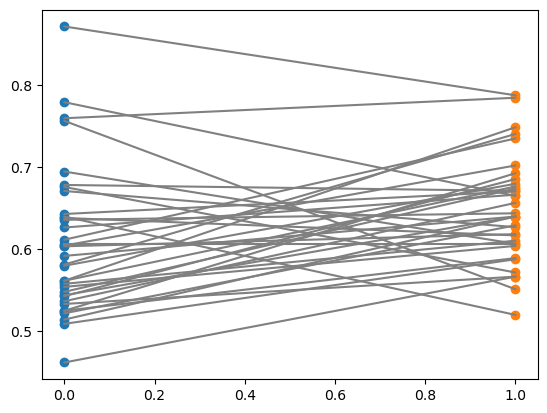

In [21]:
all_learning_wo_decodingaccs, all_learning_wi_decodingaccs
plt.scatter(np.zeros(len(cat(all_learning_wi_decodingaccs))), cat(all_learning_wi_decodingaccs))
plt.scatter(np.ones(len(cat(all_learning_wo_decodingaccs))), cat(all_learning_wo_decodingaccs))

for i in range(len(cat(all_learning_wo_decodingaccs))):
    plt.plot([0,1], [cat(all_learning_wi_decodingaccs)[i], cat(all_learning_wo_decodingaccs)[i]], color='grey')

# plt.bar([0,1], [np.mean(cat(all_learning_wi_decodingaccs)), np.mean(cat(all_learning_wo_decodingaccs))])

In [ ]:
#%% Look at cluster 1 neurons decoding on cluster 1 trials vs other cluster trials learning FOV

wi_decodingaccs = []
wo_decodingaccs = []
for cl in range(num_clusters):
    
    max_neurons_norm_arr = np.where(np.argmax(neurons_norm_arr, axis=1) == cl)[0]
    cluster_trials_all_idx = learning_normalized.index[learning_normalized['topic_{}'.format(cl)] > 0.25].to_numpy()
    # cluster_trials_all_idx = np.where(np.argmax(learning_normalized, axis=1) == cluster)[0]
    all_acc_learning = []
    for _ in range(5):

        s1 = Mode(learningpath, use_reg = True, triple=True, baseline_normalization="median_zscore",
                  filter_good_neurons=neurons_norm.index,
                    cluster_neurons=max_neurons_norm_arr,
                      i_good = cluster_trials_all_idx,
                      
                      lda_cluster=True)
                      # train_test_trials = cluster_trials_all_idx)
    
        _, _, db, acc_learning = s1.decision_boundary(mode_input='choice', persistence=False)
        all_acc_learning += [np.mean(acc_learning)]
    
    wi_decodingaccs += [np.mean(all_acc_learning)]
    
    wo_trials = [i for i in learning_normalized.index if i not in cluster_trials_all_idx]
    
    all_acc_learning = []
    for _ in range(5):

        s1 = Mode(learningpath, use_reg = True, triple=True, baseline_normalization="median_zscore",
                  filter_good_neurons=neurons_norm.index,
                    cluster_neurons=max_neurons_norm_arr,
                      i_good = wo_trials,
                      lda_cluster=True)
                      # train_test_trials = cluster_trials_all_idx)

        _, _, db, acc_learning = s1.decision_boundary(mode_input='choice', persistence=False)
        all_acc_learning += [np.mean(acc_learning)]
    
    
    wo_decodingaccs += [np.mean(all_acc_learning)]

#Plot

plt.bar(np.arange(num_clusters)-0.2, wi_decodingaccs, 0.4, label='within-cluster')
plt.bar(np.arange(num_clusters)+0.2, wo_decodingaccs, 0.4, label='without cluster')

plt.ylabel('Decoding accuracy')
plt.xticks([0,1,2,3])
plt.xlabel('Cluster')
plt.legend()
plt.ylim(bottom=0.5)

## Are CDs pruned over learning?

Need to show that the decoding accuracy of certain CDs in the learning stage do not decode well in the expert stage, whereas others do

Complementary: show that the angles of CDs are more or less aligned with the angle of the final CD


## Is there any early lick CD?

How does this lick CD align with future choice CDs? use decoding accuracy as a measure

## Which CD is chosen? 
Related to robustness?